<a href="https://colab.research.google.com/github/avindafebriza/kalbe-nutritionals-data-scientist/blob/main/ML_Regression_Avinda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

## READ DATA

In [ ]:
df_customer = pd.read_csv('Customer.csv', delimiter=';')
df_product = pd.read_csv('Product.csv', delimiter=';')
df_store = pd.read_csv('Store.csv', delimiter=';')
df_transaction = pd.read_csv('Transaction.csv', delimiter=';')

In [ ]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

## DATA CLEANSING (CUSTOMER)

In [ ]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,5.12
1,2,60,1,Married,6.23
2,3,32,1,Married,9.17
3,4,31,1,Married,4.87
4,5,58,1,Married,3.57


In [ ]:
df_customer.duplicated().sum()

In [ ]:
df_customer.isnull().sum()

In [ ]:
df_customer[df_customer['Marital Status'].isnull()]

In [ ]:
df_customer.dropna(subset=['Marital Status'], inplace=True)

In [ ]:
df_customer.dtypes

In [ ]:
# transformasi tipe data yang tidak sesuai
df_customer['Income'] = df_customer['Income'].replace(',','.',regex=True).astype('float')

## DATA CLEANSING (PRODUCT)

In [ ]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [ ]:
df_product.duplicated().sum()

In [ ]:
df_product.isnull().sum()

In [ ]:
df_product.dtypes

## DATA CLEANSING (STORE)

In [ ]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238
2,3,Prima Kota,Prima,Modern Trade,-7.797068,110.370529
3,4,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,5,Bonafid,Gita,General Trade,-7.250445,112.768845


In [ ]:
df_store.duplicated().sum()

In [ ]:
df_store.isnull().sum()

In [ ]:
df_store.dtypes

In [ ]:
# transformasi tipe data yang tidak sesuai
df_store['Latitude'] = df_store['Latitude'].replace(',','.',regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace(',','.',regex=True).astype('float')

## DATA CLEANSING (TRANSACTION)

In [ ]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,2022-01-01,P3,7500,4,30000,12
1,TR16356,165,2022-01-01,P9,10000,7,70000,1
2,TR1984,183,2022-01-01,P1,8800,4,35200,4
3,TR35256,160,2022-01-01,P1,8800,7,61600,4
4,TR41231,386,2022-01-01,P9,10000,1,10000,4


In [ ]:
df_transaction.duplicated().sum()

In [ ]:
df_transaction.isnull().sum()

In [ ]:
df_transaction.dtypes

In [ ]:
# transformasi tipe data yang tidak sesuai
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

In [ ]:
df_transaction['TransactionID'].value_counts()

In [ ]:
df_transaction[df_transaction['TransactionID'] == 'TR71313']

In [ ]:
# menghapus TransactionID yang sama dan menyisakan transaksi paling terbaru
df_cleaned = df_transaction.drop_duplicates(subset=['TransactionID'], keep='last')

In [ ]:
df_cleaned.to_csv('cleaned_dataset.csv', index=False)

In [ ]:
print(df_cleaned.head())

In [ ]:
df_cleaned['TransactionID'].value_counts()

In [ ]:
df_cleaned[df_cleaned['TransactionID'] == 'TR71313']

## MERGE DATA

In [ ]:
df_merge = pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_product.drop(columns=['Price']), on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [ ]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


## MODEL MACHINE LEARNING REGRESI

In [ ]:
df_regresi = df_merge.groupby(['Date']).agg({
    'Qty' : 'sum'
}).reset_index()

In [ ]:
df_regresi

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,40


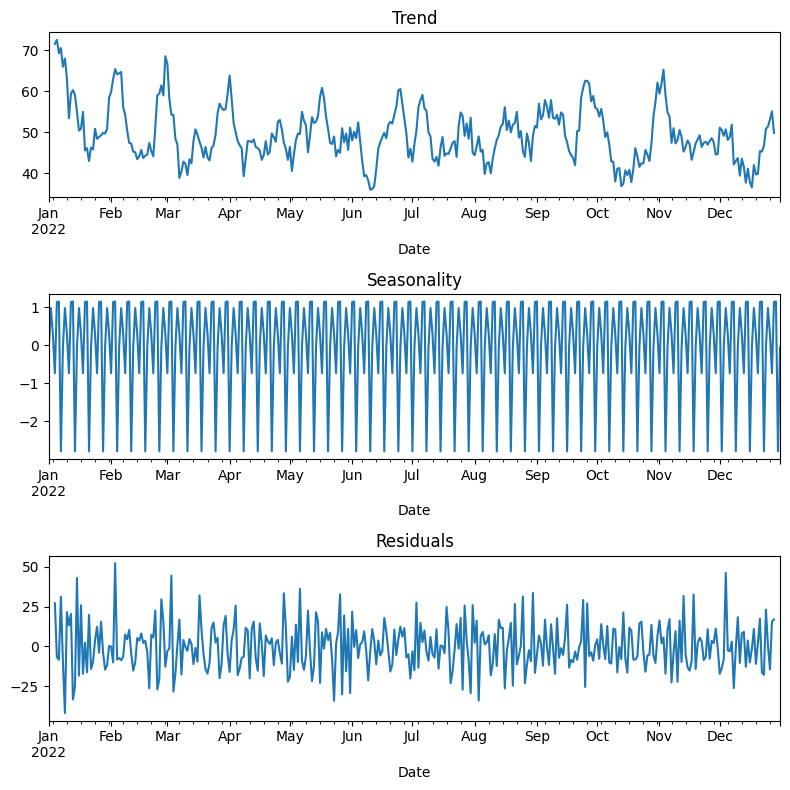

In [ ]:
decomposed = seasonal_decompose(df_regresi.set_index('Date'))

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

## CHECK STATIONARITY DATA

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_regresi['Qty'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.091514
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


## DEFINE P, D, Q VALUE

Because the P-value from ADF Test is less than 0.05 or If ADF < Critical [5%] then the time series is stationary, so there is no need to do anything hence the D value will be 0

D = 0

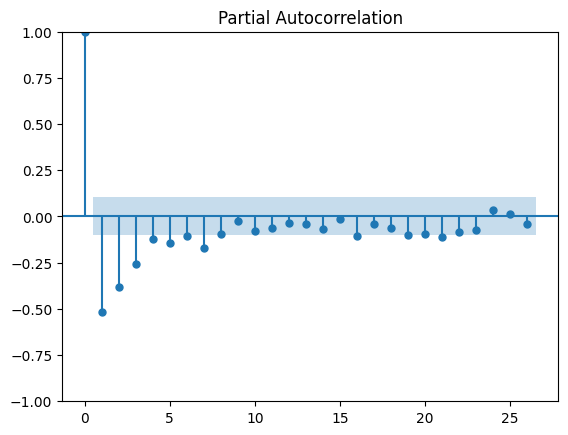

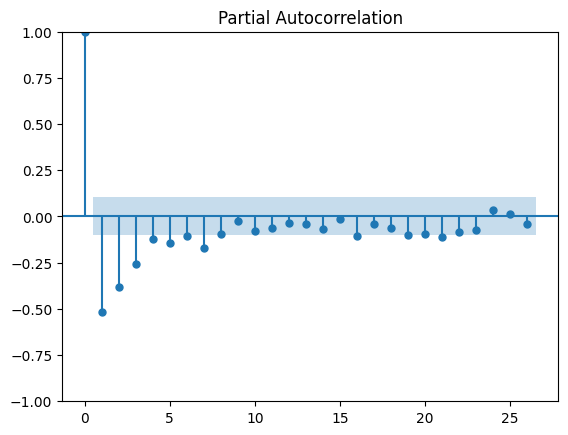

In [ ]:
# find the optimal value of P by inspecting the PACF plot
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_regresi.Qty.diff().dropna())

Due to my limited abilities, I have not been able to understand how to read the PACF plot above to get the value of P parameter.
So I tried to assume a P value based on the number of lag/antenna that were closest/inside the dense part, which was **23**.

P = 23

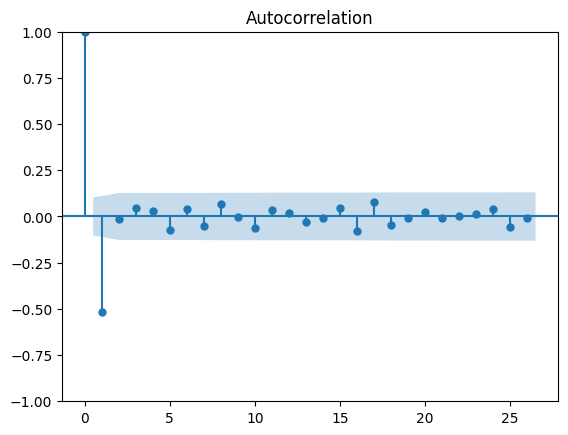

In [ ]:
# find the optimal value of Q using the ACF plot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_regresi.Qty.diff().dropna());

Due to my limited abilities, I have not been able to understand how to read the ACF plot above to get the value of P parameter.
So I tried to assume a P value based on the number of lag/antenna that were closest/inside the dense part, which was **24**.

P = 24

## SPLIT TRAINING DATA & TESTING DATA

In [ ]:
cut_off = round(df_regresi.shape[0] * 0.8)
df_train = df_regresi[:cut_off]
df_test = df_regresi[cut_off:].reset_index(drop=True)
df_train.shape, df_test.shape

((292, 2), (73, 2))

In [ ]:
df_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
287,2022-10-15,33
288,2022-10-16,24
289,2022-10-17,53
290,2022-10-18,47


In [ ]:
df_test

,Date,Qty
0,2022-10-20,39
1,2022-10-21,35
2,2022-10-22,56
3,2022-10-23,59
4,2022-10-24,39
...,...,...
68,2022-12-27,70
69,2022-12-28,68
70,2022-12-29,42
71,2022-12-30,40


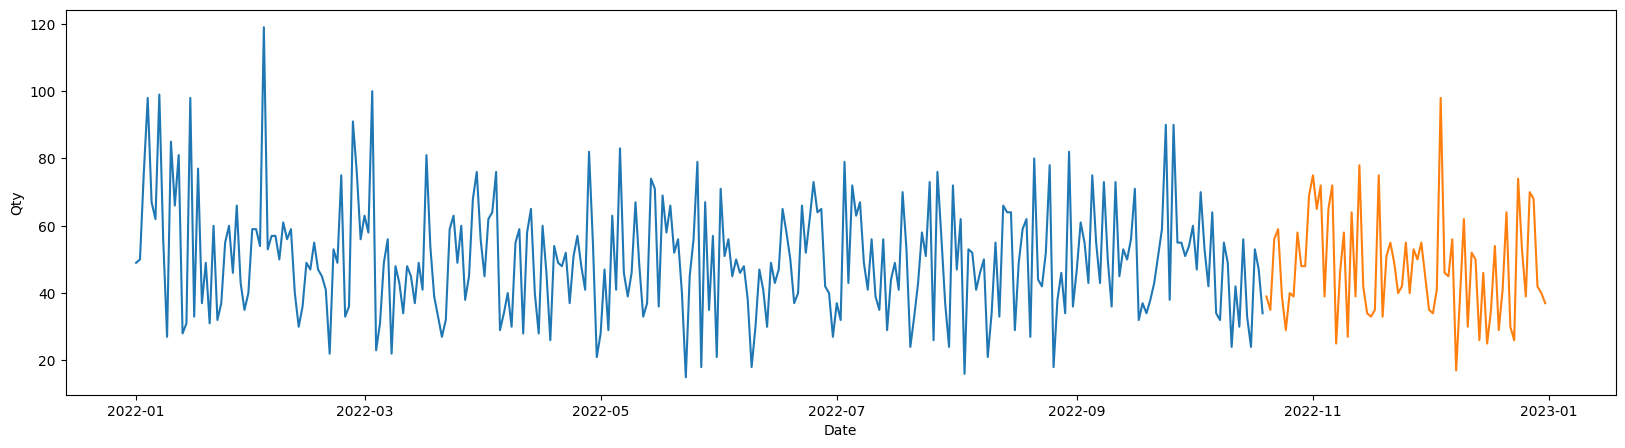

In [ ]:
# visualisasi data training dan data testing

plt.figure(figsize=(20,5))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty']);
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty']);

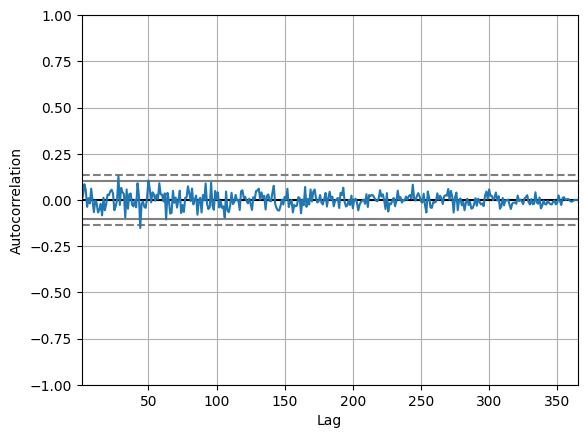

In [ ]:
autocorrelation_plot(df_regresi['Qty']);

## RMSE

In [ ]:
# menghitung RMSE

def rmse(y_actual, y_pred):
  """
  function to calculate RMSE
  """

  print(f'RMSE value {mean_squared_error(y_actual, y_pred)**0.5}')

def eval(y_actual, y_pred):
  """
  function to eval machine learning modelling
  """

  rmse(y_actual, y_pred)
  print(f'MAE value {mean_absolute_error(y_actual, y_pred)}')

## ARIMA MODEL PREDICTION

RMSE value 16.660087485445708
MAE value 13.655045446260264


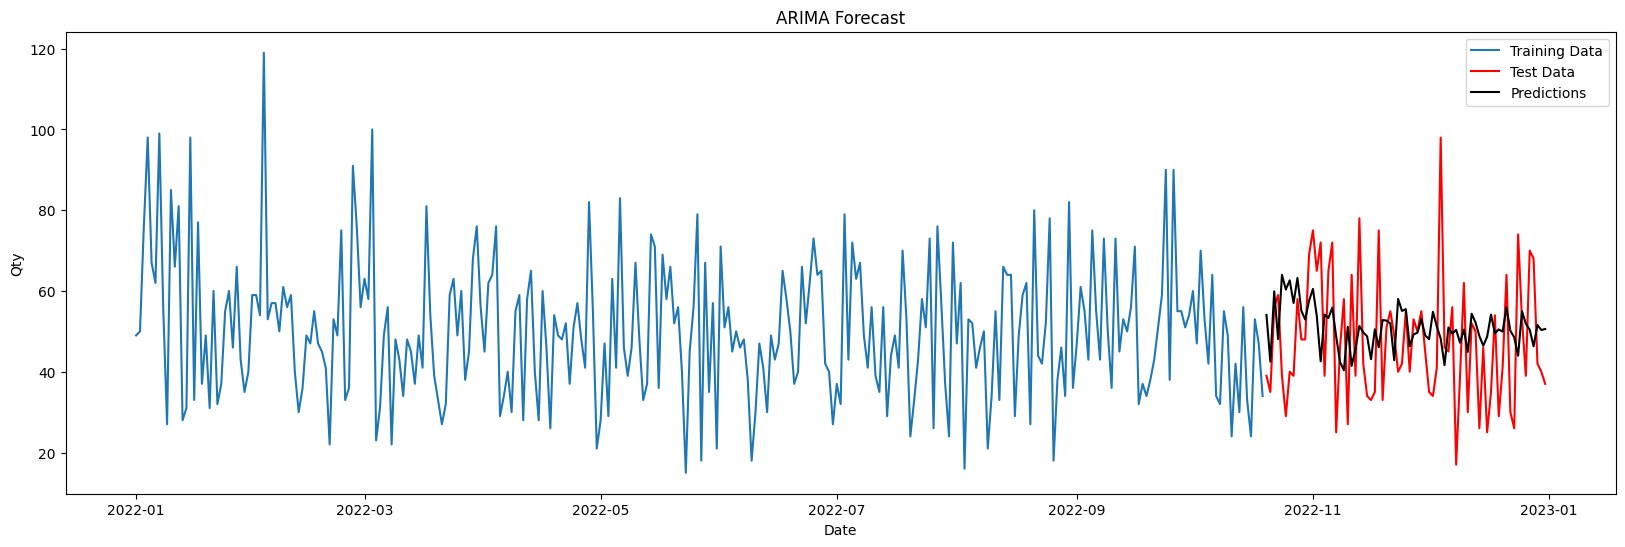

In [ ]:
# membuat prediction dengan model ARIMA
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

y = df_train['Qty']

ARIMAmodel = ARIMA(y, order = (23, 0, 24))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start =y_pred_df.index[0], end =y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']
eval(df_test['Qty'], y_pred_out)

plt.figure(figsize=(20, 6))
plt.plot(df_train['Qty'], label='Training Data')
plt.plot(df_test['Qty'], color='red', label='Test Data')
plt.plot(y_pred_out, color='black', label='Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('ARIMA Forecast')
plt.show()